In [1]:
import pandas as pd
import numpy as np


In [2]:
# Load the dataset
df = pd.read_csv('data/dallas_mapillary_image_data.csv')
df.head()

,id,captured_at_ms,lon,lat,url
0,3000128076936343,1563194409169,-96.990647,32.651946,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...
1,614767679922514,1565628630986,-96.996129,32.650297,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...
2,767348750645894,1563117567610,-96.996703,32.657790,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...
3,111547250997651,1563195041386,-96.997073,32.655536,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...
4,1423856261314726,1563194756135,-96.996408,32.654705,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...


In [3]:
df.shape

(11391083, 5)

In [ ]:
# Filter Dallas City Data using latitude and longitude and shapefile
# Load the shapefile
import geopandas as gpd
shapefile_path = 'data/dallas_boundary/CityLimits.shp'
city_boundary = gpd.read_file(shapefile_path)

In [11]:
# Filter Dallas City Data
dallas_boundary = city_boundary[city_boundary['CITY'] == 'Dallas']

# Convert the geometry to WGS 84 (EPSG:4326) if necessary
if dallas_boundary.crs != 'EPSG:4326':
    dallas_boundary = dallas_boundary.to_crs('EPSG:4326')

In [12]:
dallas_boundary

,OBJECTID,CITY,Shape__Are,Shape__Len,geometry
3,4,Dallas,1.069285e+10,1.706327e+06,"POLYGON ((-96.54985 32.84813, -96.54987 32.848..."


In [10]:
city_boundary.head()

,OBJECTID,CITY,Shape__Are,Shape__Len,geometry
0,1,Cockrell Hill,1.624401e+07,2.407435e+04,"POLYGON ((2463090.909 6956820.015, 2464369.03 ..."
1,2,Unincorporated,1.679436e+06,1.796918e+04,"POLYGON ((2562435.979 6991704.722, 2561581.161..."
2,3,Park Cities,1.655319e+08,6.579923e+04,"POLYGON ((2495598.701 7002077.923, 2495643.117..."
3,4,Dallas,1.069285e+10,1.706327e+06,"POLYGON ((2567339.392 6997052.264, 2567332.864..."


In [ ]:
# Convert the DataFrame to a GeoDataFrame
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [14]:
# Set the coordinate reference system (CRS) to match the shapefile
gdf.crs = dallas_boundary.crs

In [16]:
# Perform spatial join to filter points within the city boundary
filtered_gdf = gpd.sjoin(gdf, dallas_boundary, predicate='within')

# Convert back to DataFrame
filtered_df = pd.DataFrame(filtered_gdf.drop(columns='geometry'))

In [17]:
filtered_gdf.shape

(8441229, 11)

In [19]:
filtered_gdf.head()

,id,captured_at_ms,lon,lat,url,geometry,index_right,OBJECTID,CITY,Shape__Are,Shape__Len
5,267568523067837,1701790513993,-96.987557,32.652768,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...,POINT (-96.98756 32.65277),3,4,Dallas,1.069285e+10,1.706327e+06
9,371223484293513,1563118308497,-96.987680,32.652713,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...,POINT (-96.98768 32.65271),3,4,Dallas,1.069285e+10,1.706327e+06
12,950916033303482,1701790498993,-96.988281,32.652519,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...,POINT (-96.98828 32.65252),3,4,Dallas,1.069285e+10,1.706327e+06
13,315774529923802,1563194406165,-96.990057,32.652108,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...,POINT (-96.99006 32.65211),3,4,Dallas,1.069285e+10,1.706327e+06
14,302215731347260,1563196416603,-96.987364,32.652813,https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...,POINT (-96.98736 32.65281),3,4,Dallas,1.069285e+10,1.706327e+06


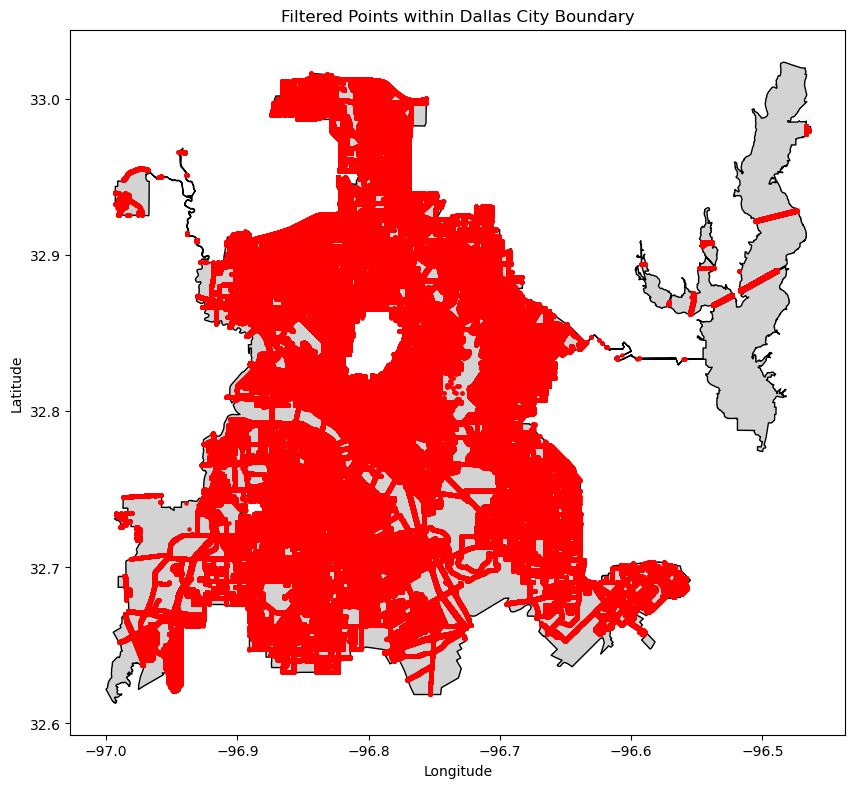

In [20]:
# plot the filtered points (map)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
dallas_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
filtered_gdf.plot(ax=ax, color='red', markersize=5)
plt.title('Filtered Points within Dallas City Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [22]:
# Save the filtered dataframe to a CSV file
filtered_df[['id','captured_at_ms','lon','lat','url']].to_csv('data/filtered_dallas_mapillary_image_data.csv', index=False)

In [23]:
filtered_df.shape

(8441229, 10)

In [24]:
# Divide the filtered DataFrame into four parts
filtered_df1 = filtered_df.iloc[:len(filtered_df)//4]
filtered_df2 = filtered_df.iloc[len(filtered_df)//4:len(filtered_df)//2]
filtered_df3 = filtered_df.iloc[len(filtered_df)//2:3*len(filtered_df)//4]
filtered_df4 = filtered_df.iloc[3*len(filtered_df)//4:]

filtered_df1 = filtered_df1.reset_index(drop=True)
filtered_df2 = filtered_df2.reset_index(drop=True)
filtered_df3 = filtered_df3.reset_index(drop=True)
filtered_df4 = filtered_df4.reset_index(drop=True)

# Save the divided DataFrames to CSV files
filtered_df1[['id','captured_at_ms','lon','lat','url']].to_csv('data/filtered_dallas_mapillary_image_data_part1.csv', index=False)
filtered_df2[['id','captured_at_ms','lon','lat','url']].to_csv('data/filtered_dallas_mapillary_image_data_part2.csv', index=False)
filtered_df3[['id','captured_at_ms','lon','lat','url']].to_csv('data/filtered_dallas_mapillary_image_data_part3.csv', index=False)
filtered_df4[['id','captured_at_ms','lon','lat','url']].to_csv('data/filtered_dallas_mapillary_image_data_part4.csv', index=False)